<a href="https://colab.research.google.com/github/Elenanda/Penambangan_Data/blob/main/CRISP_DM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ---------------------------------------------------------------------------
# --- FASE 1 & 2: BUSINESS UNDERSTANDING & DATA UNDERSTANDING (SETUP & EDA) ---
# ---------------------------------------------------------------------------
# Tujuan: Memuat data dan melakukan eksplorasi awal untuk memahami isinya.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

In [ ]:
# URL langsung ke file CSV
url = 'https://raw.githubusercontent.com/IBM/telco-customer-churn-on-icp4d/master/data/Telco-Customer-Churn.csv'

In [ ]:
# Membaca data menggunakan pandas
df = pd.read_csv(url)

In [ ]:
print("\n--- Info Awal Dataset ---")
print(df.info())


--- Info Awal Dataset ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBillin

In [ ]:
# Menampilkan 5 baris pertama dari data untuk memastikan berhasil dimuat
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [ ]:
print("\n--- Statistik Deskriptif ---")
print(df.describe())


--- Statistik Deskriptif ---
       SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000


In [ ]:
print("\n--- Distribusi Target Variable (Churn) ---")
print(df['Churn'].value_counts())


--- Distribusi Target Variable (Churn) ---
Churn
No     5174
Yes    1869
Name: count, dtype: int64


In [ ]:
# ---------------------------------------------------------------------------
# --- FASE 3: DATA PREPARATION (PERSIAPAN DATA) ---
# ---------------------------------------------------------------------------
# Tujuan: Membersihkan dan mentransformasi data agar siap untuk pemodelan.

print("\nMemulai proses persiapan data...")

# 1. Menangani CustomerID yang tidak relevan
df = df.drop('customerID', axis=1)


Memulai proses persiapan data...


In [ ]:
# 2. Menangani 'TotalCharges' yang seharusnya numerik
# Mengubah 'TotalCharges' menjadi numerik, error akan menjadi NaN (Not a Number)
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

In [ ]:
# Menghapus baris yang memiliki nilai NaN (jumlahnya sedikit, jadi aman dihapus)
df.dropna(inplace=True)

In [ ]:
# 3. Memisahkan fitur (X) dan target (y)
X = df.drop('Churn', axis=1)
y = df['Churn'].apply(lambda x: 1 if x == 'Yes' else 0) # Mengubah Yes/No menjadi 1/0

In [ ]:
# Membagi data menjadi data latih dan data uji (80% latih, 20% uji)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\nData dibagi menjadi {X_train.shape[0]} baris data latih dan {X_test.shape[0]} baris data uji.")


Data dibagi menjadi 5625 baris data latih dan 1407 baris data uji.


In [ ]:
# 5. Membuat pipeline untuk preprocessing
# Preprocessing akan menangani variabel numerik dan kategorikal secara berbeda.

# Identifikasi kolom numerik dan kategorikal
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
categorical_features = X.select_dtypes(include=['object']).columns

In [ ]:
# Membuat transformer untuk setiap jenis kolom
numeric_transformer = StandardScaler() # Scaling untuk numerik
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # One-Hot Encoding untuk kategorikal

In [ ]:
# Menggabungkan transformer menggunakan ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

print("Pipeline preprocessing berhasil dibuat.")

Pipeline preprocessing berhasil dibuat.


In [ ]:
# ---------------------------------------------------------------------------
# --- FASE 4: MODELING (PEMODELAN) ---
# ---------------------------------------------------------------------------
# Tujuan: Membangun model machine learning menggunakan data yang telah disiapkan.
# Kita akan menggunakan Random Forest Classifier karena performanya yang baik.

print("\nMemulai proses pemodelan...")

# Membuat pipeline lengkap yang menggabungkan preprocessing dan model
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', RandomForestClassifier(random_state=42))])


Memulai proses pemodelan...


In [ ]:
# Melatih model menggunakan data latih
model.fit(X_train, y_train)

print("Model berhasil dilatih!")

Model berhasil dilatih!


In [ ]:
# ---------------------------------------------------------------------------
# --- FASE 5: EVALUATION (EVALUASI) ---
# ---------------------------------------------------------------------------
# Tujuan: Mengevaluasi performa model pada data uji yang belum pernah dilihat sebelumnya.

print("\nMemulai evaluasi model...")

# Melakukan prediksi pada data uji
y_pred = model.predict(X_test)


Memulai evaluasi model...


In [ ]:
# Menampilkan hasil evaluasi
accuracy = accuracy_score(y_test, y_pred)
print(f"\nAkurasi Model: {accuracy:.4f}")


Akurasi Model: 0.7754


In [ ]:
print("\nLaporan Klasifikasi Lengkap:")
print(classification_report(y_test, y_pred, target_names=['Tidak Churn', 'Churn']))


Laporan Klasifikasi Lengkap:
              precision    recall  f1-score   support

 Tidak Churn       0.82      0.89      0.85      1033
       Churn       0.60      0.46      0.52       374

    accuracy                           0.78      1407
   macro avg       0.71      0.68      0.69      1407
weighted avg       0.76      0.78      0.77      1407




Confusion Matrix:


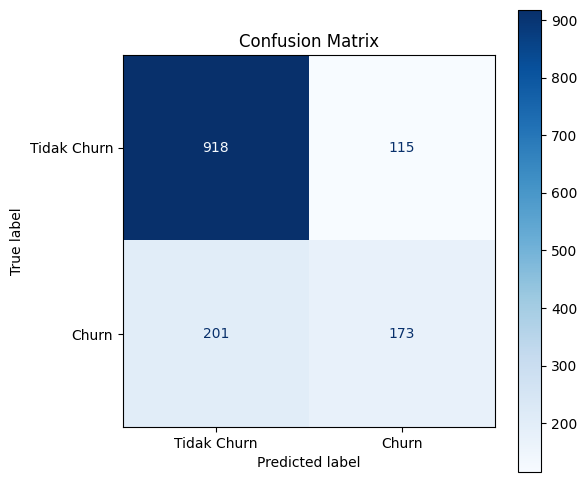

In [ ]:
print("\nConfusion Matrix:")
# Menampilkan visualisasi confusion matrix
fig, ax = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, display_labels=['Tidak Churn', 'Churn'], cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# ---------------------------------------------------------------------------
# --- FASE 6: DEPLOYMENT (SIMULASI PENYEBARAN) ---
# ---------------------------------------------------------------------------
# Tujuan: Mensimulasikan bagaimana model akan digunakan untuk memprediksi pelanggan baru.
# Kita akan membuat fungsi yang menerima data pelanggan baru dan memberikan prediksi.

print("\n--- Simulasi Deployment ---")

def prediksi_churn_pelanggan_baru(data_pelanggan):
    """
    Fungsi untuk memprediksi churn pada data pelanggan baru.
    Input: sebuah dictionary berisi data pelanggan.
    Output: string hasil prediksi.
    """
    # Mengubah dictionary menjadi DataFrame
    df_pelanggan = pd.DataFrame([data_pelanggan])

    # Melakukan prediksi menggunakan model yang sudah dilatih
    prediksi = model.predict(df_pelanggan)
    probabilitas = model.predict_proba(df_pelanggan)

    # Menginterpretasikan hasil
    if prediksi[0] == 1:
        hasil = f"🚨 PREDIKSI: Pelanggan ini BERPOTENSI TINGGI untuk CHURN (Probabilitas: {probabilitas[0][1]:.2%})"
    else:
        hasil = f"✅ PREDIKSI: Pelanggan ini kemungkinan BESAR akan TETAP BERLANGGANAN (Probabilitas Churn: {probabilitas[0][1]:.2%})"

    return hasil



--- Simulasi Deployment ---


In [ ]:
# CONTOH PENGGUNAAN FUNGSI DEPLOYMENT

# Contoh 1: Pelanggan yang berisiko tinggi untuk churn
# (Kontrak bulanan, baru berlangganan, internet Fiber optic, tagihan tinggi)
pelanggan_berisiko = {
    'gender': 'Female', 'SeniorCitizen': 0, 'Partner': 'No', 'Dependents': 'No',
    'tenure': 2, 'PhoneService': 'Yes', 'MultipleLines': 'No',
    'InternetService': 'Fiber optic', 'OnlineSecurity': 'No', 'OnlineBackup': 'No',
    'DeviceProtection': 'No', 'TechSupport': 'No', 'StreamingTV': 'No',
    'StreamingMovies': 'No', 'Contract': 'Month-to-month', 'PaperlessBilling': 'Yes',
    'PaymentMethod': 'Electronic check', 'MonthlyCharges': 75.50, 'TotalCharges': 150.50
}

In [ ]:
print("\n--- Memprediksi Pelanggan Baru ---")
print("\nKasus 1: Pelanggan Berisiko")
print(prediksi_churn_pelanggan_baru(pelanggan_berisiko))


--- Memprediksi Pelanggan Baru ---

Kasus 1: Pelanggan Berisiko
🚨 PREDIKSI: Pelanggan ini BERPOTENSI TINGGI untuk CHURN (Probabilitas: 83.00%)


In [ ]:
# Contoh 2: Pelanggan setia yang berisiko rendah
# (Kontrak dua tahun, sudah lama berlangganan, banyak layanan proteksi)
pelanggan_setia = {
    'gender': 'Male', 'SeniorCitizen': 0, 'Partner': 'Yes', 'Dependents': 'Yes',
    'tenure': 68, 'PhoneService': 'Yes', 'MultipleLines': 'Yes',
    'InternetService': 'DSL', 'OnlineSecurity': 'Yes', 'OnlineBackup': 'Yes',
    'DeviceProtection': 'Yes', 'TechSupport': 'Yes', 'StreamingTV': 'Yes',
    'StreamingMovies': 'Yes', 'Contract': 'Two year', 'PaperlessBilling': 'No',
    'PaymentMethod': 'Credit card (automatic)', 'MonthlyCharges': 85.50, 'TotalCharges': 5800.00
}

In [ ]:
print("\nKasus 2: Pelanggan Setia")
print(prediksi_churn_pelanggan_baru(pelanggan_setia))


Kasus 2: Pelanggan Setia
✅ PREDIKSI: Pelanggan ini kemungkinan BESAR akan TETAP BERLANGGANAN (Probabilitas Churn: 0.00%)
